# [Genre] Experiment 2 - Different Number of Layers
In the second experiment, I evaluate five architectures (CNN-{3,4,5,6,7}) with mel spectrogram input.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import sys
import os
import json
import pickle
import csv
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Activation, BatchNormalization, ReLU, Conv1D, MaxPooling1D
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
DRIVE_PATH = '/content/drive/My Drive/'
sys.path.append(DRIVE_PATH)

import utility
from utility import DataGenerator

SPLITS_DIR = DRIVE_PATH + 'genre-splits/experiment-2/'
MELSPECS_DIR = DRIVE_PATH + 'genre-melspecs-19000/'
MODELS_DIR = DRIVE_PATH + 'genre-models/experiment-2/'
RESULTS_DIR = DRIVE_PATH + 'genre-results/'
PICKLES_DIR = DRIVE_PATH + 'genre-pickles/'

NUM_CLASSES = 10
NUM_EPOCHS = 20
BATCH_SIZE = 128

# 1. Loading the data

In [ ]:
# Loading the label map
with open(DRIVE_PATH + 'genre_label_map.json', 'r') as output:
    label_map = json.load(output)

label_map

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [ ]:
inv_label_map = {v: k for k,v in label_map.items()}
inv_label_map

{0: 'blues',
 1: 'classical',
 2: 'country',
 3: 'disco',
 4: 'hiphop',
 5: 'jazz',
 6: 'metal',
 7: 'pop',
 8: 'reggae',
 9: 'rock'}

In [ ]:
# Loading the splits
X_train_filenames = np.load(SPLITS_DIR + 'X_train_filenames_melspec.npy')
X_val_filenames = np.load(SPLITS_DIR + 'X_val_filenames_melspec.npy')
X_test_filenames = np.load(SPLITS_DIR + 'X_test_filenames_melspec.npy')

one_hot_y_train = np.load(SPLITS_DIR + 'one_hot_y_train_melspec.npy')
one_hot_y_val = np.load(SPLITS_DIR + 'one_hot_y_val_melspec.npy')
one_hot_y_test = np.load(SPLITS_DIR + 'one_hot_y_test_melspec.npy')

In [ ]:
print('Mel spectrograms')
print("Train set:", X_train_filenames.shape, one_hot_y_train.shape)
print("Validation set:", X_val_filenames.shape, one_hot_y_val.shape)
print("Test set:", X_test_filenames.shape, one_hot_y_test.shape)

Mel spectrograms
Train set: (15200,) (15200, 10)
Validation set: (1900,) (1900, 10)
Test set: (1900,) (1900, 10)


# 2. Creating generators

In [ ]:
# Replacing filenames by the absolute path to filenames
X_train_filenames = np.array([MELSPECS_DIR + fn for fn in X_train_filenames])
X_val_filenames = np.array([MELSPECS_DIR + fn for fn in X_val_filenames])
X_test_filenames = np.array([MELSPECS_DIR + fn for fn in X_test_filenames])

In [ ]:
x = np.load(X_train_filenames[0])
melspec_shape = x.shape
melspec_shape

(128, 130)

In [ ]:
train_generator = DataGenerator(X_train_filenames, one_hot_y_train, BATCH_SIZE, melspec_shape, 1)
validation_generator = DataGenerator(X_val_filenames, one_hot_y_val, BATCH_SIZE, melspec_shape, 1)
test_generator = DataGenerator(X_test_filenames, one_hot_y_test, BATCH_SIZE, melspec_shape, 1)

# 3. Building and training the models
Architecture inspired and adapted from Choi et al. [[1]](#one) 

In [ ]:
def build_cnn(input_shape, nb_filters, dense_units, nb_conv=3, output_shape=NUM_CLASSES, activation='softmax', dropout=0.3, poolings=None):
    
    n_mels = input_shape[0]
    
    if not poolings:
      if n_mels >= 256:
          poolings = [(2, 4), (4, 4), (4, 5), (2, 4), (4, 4)]
      elif n_mels >= 128:
          poolings = [(2, 4), (4, 4), (2, 5), (2, 4), (4, 4)]
      elif n_mels >= 96:
          poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (4, 4)]
      elif n_mels >= 72:
          poolings = [(2, 4), (3, 4), (2, 5), (2, 4), (3, 4)]
      elif n_mels >= 64:
          poolings = [(2, 4), (2, 4), (2, 5), (2, 4), (4, 4)]
    
    # Input block
    melspec_input = Input(shape=input_shape, name='input')

    # Conv block 1
    x = Conv2D(nb_filters[0], (3, 3), activation='relu', name='conv2D_1')(melspec_input)
    x = MaxPooling2D(pool_size=poolings[0], strides=2, padding='same', name='pool_1')(x)
    x = BatchNormalization(name='bn_1')(x)
    
    # Conv block 2
    x = Conv2D(nb_filters[1], (3, 3), activation='relu', name='conv2D_2')(x)
    x = MaxPooling2D(pool_size=poolings[1], strides=2, padding='same', name='pool_2')(x)
    x = BatchNormalization(name='bn_2')(x)
    
    # Conv block 3
    x = Conv2D(nb_filters[2], (3, 3), activation='relu', name='conv2D_3')(x)
    x = MaxPooling2D(pool_size=poolings[2], strides=2, padding='same', name='pool_3')(x)
    x = BatchNormalization(name='bn_3')(x)

    # Conv block 4
    if nb_conv >= 4:        
      x = Conv2D(nb_filters[3], (3, 3), activation='relu', name='conv2D_4')(x)
      x = MaxPooling2D(pool_size=poolings[3], strides=2, padding='same', name='pool_4')(x)
      x = BatchNormalization(name='bn_4')(x)

    # Conv block 5
    if nb_conv >= 5:
      x = Conv2D(nb_filters[4], (3, 3), activation='relu', name='conv2D_5')(x)
      x = MaxPooling2D(pool_size=poolings[4], strides=2, padding='same', name='pool_5')(x)
      x = BatchNormalization(name='bn_5')(x)

    # Conv block 6
    if nb_conv >= 6:
      x = Conv2D(nb_filters[5], (1,1) , activation='relu', name='conv2D_6')(x)

    # Conv block 7
    if nb_conv >= 7:
      x = Conv2D(nb_filters[6], (1,1) , activation='relu', name='conv2D_7')(x)

    # Flattening the output and feeding it into dense layer
    x = Flatten(name='flatten')(x)
    x = Dense(dense_units, activation='relu', name='dense')(x)
    x = Dropout(dropout, name='dropout')(x)
    
    # Output Layer
    x = Dense(output_shape, activation=activation, name = 'dense_output')(x)
    
    # Create model
    model = Model(melspec_input, x)
    
    return model

In [ ]:
def create_checkpoint(filepath):
  checkpoint = ModelCheckpoint(filepath, 
                            monitor='val_accuracy', 
                            verbose=0, 
                            save_best_only=False)
  return checkpoint

In [ ]:
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.1, 
                                         patience=1, 
                                         verbose=0)

In [ ]:
def train_cnn(checkpoint_path, 
              input_shape=(melspec_shape[0], melspec_shape[1], 1), nb_filters=[32,32,32,64,64,128,128], 
              dense_units=64, nb_conv=3, output_shape=NUM_CLASSES, activation='softmax', dropout=0.3, poolings=None):
  
  # Creating callbacks list
  callbacks_list = [create_checkpoint(checkpoint_path), reduce_lr_on_plateau]

  # Building the network
  cnn = build_cnn(input_shape=input_shape, nb_filters=nb_filters, dense_units=dense_units, nb_conv=nb_conv, output_shape=output_shape, activation=activation, dropout=dropout, poolings=poolings)
  cnn.summary()

  # Compiling the network
  cnn.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(0.001),
              metrics=['accuracy'])
  
  # Training the network
  cnn_hist = cnn.fit(x=train_generator,
                      epochs=NUM_EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=validation_generator,
                      validation_steps=VAL_STEPS,
                      callbacks=callbacks_list)
  
  return cnn, cnn_hist

In [ ]:
STEPS_PER_EPOCH = np.ceil(len(X_train_filenames)/BATCH_SIZE)
VAL_STEPS = np.ceil(len(X_val_filenames)/BATCH_SIZE)
TEST_STEPS = np.ceil(len(X_test_filenames)/BATCH_SIZE)

## 3-layer CNN

In [ ]:
cnn_3, cnn_3_hist = train_cnn(nb_conv=3, checkpoint_path=MODELS_DIR + '3-layers/cnn_3_mel_epoch_{epoch:02d}_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 130, 1)]     0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 126, 128, 32)      320       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 63, 64, 32)        0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 63, 64, 32)        128       
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 61, 62, 32)        9248      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 31, 31, 32)        0         
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 31, 31, 32)        128   

In [ ]:
# Saving scores on train and validation sets
with open(PICKLES_DIR + 'exp_2_cnn_3_mel_history.pkl', 'wb') as f:
    pickle.dump(cnn_3_hist.history, f)

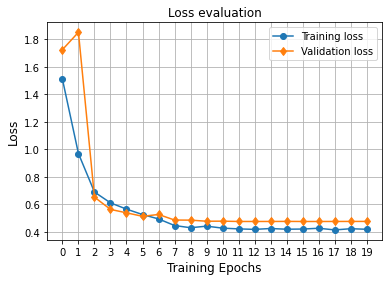

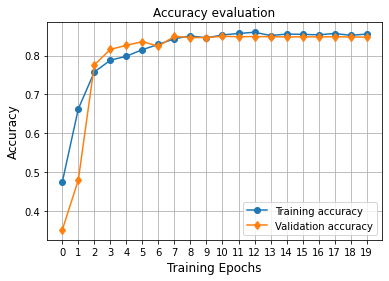

In [ ]:
# Loading scores
with open(PICKLES_DIR + 'exp_2_cnn_3_mel_history.pkl', 'rb') as f:
    cnn_3_hist_dict = pickle.load(f)

utility.plot_history(cnn_3_hist_dict, num_epochs=NUM_EPOCHS, save_path=MODELS_DIR + '3-layers/cnn_3_melspec')

In [ ]:
# Loading the best performing model
cnn_3 = load_model(filepath=MODELS_DIR + '3-layers/cnn_3_mel_epoch_14_acc_0.8515_val_acc_0.8484.h5')

## 4-layer CNN

In [ ]:
cnn_4, cnn_4_hist = train_cnn(nb_conv=4, checkpoint_path=MODELS_DIR + '4-layers/cnn_4_mel_epoch_{epoch:02d}_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 130, 1)]     0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 126, 128, 32)      320       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 63, 64, 32)        0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 63, 64, 32)        128       
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 61, 62, 32)        9248      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 31, 31, 32)        0         
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 31, 31, 32)        128 

In [ ]:
# Saving scores on train and validation sets
with open(PICKLES_DIR + 'exp_2_cnn_4_mel_history.pkl', 'wb') as f:
    pickle.dump(cnn_4_hist.history, f)

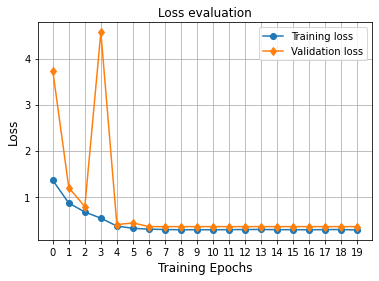

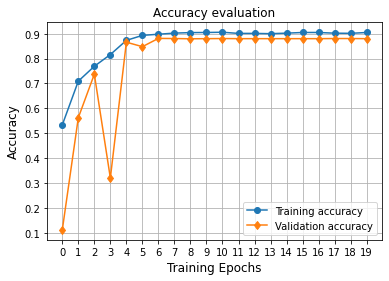

In [ ]:
# Loading scores
with open(PICKLES_DIR + 'exp_2_cnn_4_mel_history.pkl', 'rb') as f:
    cnn_4_hist_dict = pickle.load(f)

utility.plot_history(cnn_4_hist_dict, num_epochs=NUM_EPOCHS, save_path=MODELS_DIR + '4-layers/cnn_4_melspec')

In [ ]:
# Loading the best performing model
cnn_4 = load_model(filepath=MODELS_DIR + '4-layers/cnn_4_mel_epoch_11_acc_0.9058_val_acc_0.8805.h5')

## 5-layer CNN

In [ ]:
# 2H
cnn_5, cnn_5_hist = train_cnn(nb_conv=5, checkpoint_path=MODELS_DIR + '5-layers/cnn_5_mel_epoch_{epoch:02d}_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 130, 1)]     0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 126, 128, 32)      320       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 63, 64, 32)        0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 63, 64, 32)        128       
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 61, 62, 32)        9248      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 31, 31, 32)        0         
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 31, 31, 32)        128 

In [ ]:
# Saving scores on train and validation sets
with open(PICKLES_DIR + 'exp_2_cnn_5_mel_history.pkl', 'wb') as f:
    pickle.dump(cnn_5_hist.history, f)

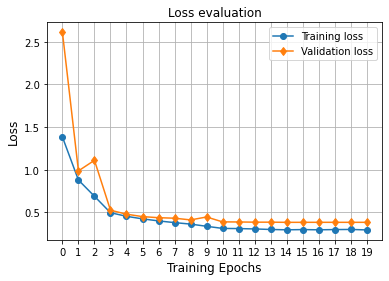

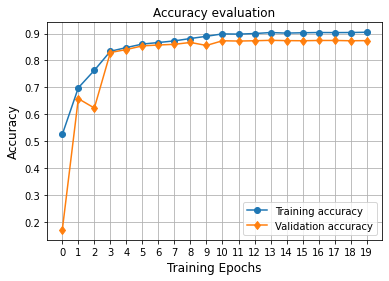

In [ ]:
# Loading scores
with open(PICKLES_DIR + 'exp_2_cnn_5_mel_history.pkl', 'rb') as f:
    cnn_5_hist_dict = pickle.load(f)

utility.plot_history(cnn_5_hist_dict, num_epochs=NUM_EPOCHS, save_path=MODELS_DIR + '5-layers/cnn_5_melspec')

In [ ]:
# Loading the best performing model
cnn_5 = load_model(filepath=MODELS_DIR + '5-layers/cnn_5_mel_epoch_15_acc_0.9016_val_acc_0.8737.h5')

## 6-layer CNN

In [ ]:
# 2H
cnn_6, cnn_6_hist = train_cnn(nb_conv=6, checkpoint_path=MODELS_DIR + '6-layers/cnn_6_mel_epoch_{epoch:02d}_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 130, 1)]     0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 126, 128, 32)      320       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 63, 64, 32)        0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 63, 64, 32)        128       
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 61, 62, 32)        9248      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 31, 31, 32)        0         
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 31, 31, 32)        128 

In [ ]:
# Saving scores on train and validation sets
with open(PICKLES_DIR + 'exp_2_cnn_6_mel_history.pkl', 'wb') as f:
    pickle.dump(cnn_6_hist.history, f)

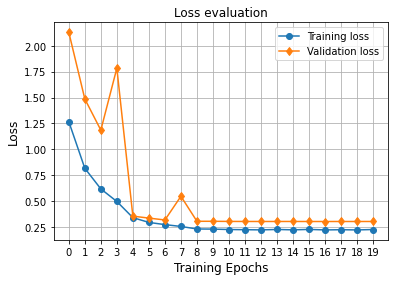

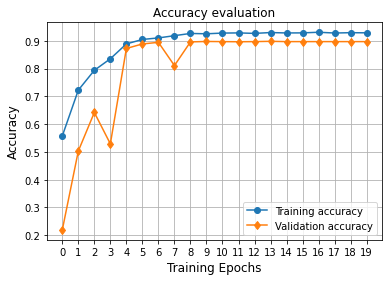

In [ ]:
# Loading scores
with open(PICKLES_DIR + 'exp_2_cnn_6_mel_history.pkl', 'rb') as f:
    cnn_6_hist_dict = pickle.load(f)

utility.plot_history(cnn_6_hist_dict, num_epochs=NUM_EPOCHS, save_path=MODELS_DIR + '6-layers/cnn_6_melspec')

In [ ]:
# Loading the best performing model
cnn_6 = load_model(filepath=MODELS_DIR + '6-layers/cnn_6_mel_epoch_11_acc_0.9281_val_acc_0.8974.h5')

## 7-layer CNN

In [ ]:
# 2H
cnn_7, cnn_7_hist = train_cnn(nb_conv=7, checkpoint_path=MODELS_DIR + '7-layers/cnn_7_mel_epoch_{epoch:02d}_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 130, 1)]     0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 126, 128, 32)      320       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 63, 64, 32)        0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 63, 64, 32)        128       
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 61, 62, 32)        9248      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 31, 31, 32)        0         
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 31, 31, 32)        128 

In [ ]:
# Saving scores on train and validation sets
with open(PICKLES_DIR + 'exp_2_cnn_7_mel_history.pkl', 'wb') as f:
    pickle.dump(cnn_7_hist.history, f)

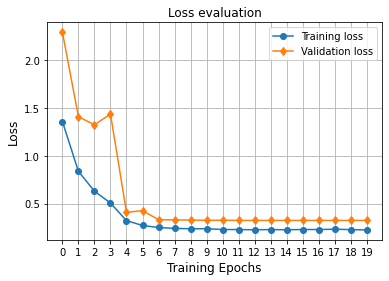

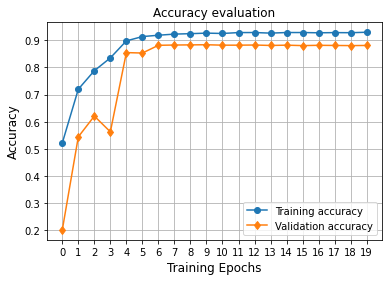

In [ ]:
# Loading scores
with open(PICKLES_DIR + 'exp_2_cnn_7_mel_history.pkl', 'rb') as f:
    cnn_7_hist_dict = pickle.load(f)

utility.plot_history(cnn_7_hist_dict, num_epochs=NUM_EPOCHS, save_path=MODELS_DIR + '7-layers/cnn_7_melspec')

In [ ]:
# Loading the best performing model
cnn_7 = load_model(filepath=MODELS_DIR + '7-layers/cnn_7_mel_epoch_09_acc_0.9239_val_acc_0.8826.h5')

# 4. Save scores

## 4.1. Macro-average Scores


In [ ]:
y_test = np.argmax(one_hot_y_test, axis=1)

In [ ]:
def make_predictions(model):
  pred_proba = model.predict(x=test_generator, steps=TEST_STEPS)
  y_pred = np.argmax(pred_proba, axis=1)
  return pred_proba, y_pred

In [ ]:
def compute_scores(y_true, y_pred, one_hot_y_true, pred_proba):
  accuracy = accuracy_score(y_pred, y_true)
  precision_macro = precision_score(y_pred, y_true, average='macro')
  recall_macro = recall_score(y_pred, y_true, average='macro', labels=np.unique(y_pred))
  f1_score_macro = f1_score(y_pred, y_true, average='macro')
  roc_auc_macro = roc_auc_score(one_hot_y_true, pred_proba, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision macro: {precision_macro}')
  print(f'Recall macro: {recall_macro}')
  print(f'F1 score macro: {f1_score_macro}')
  print(f'ROC AUC macro: {roc_auc_macro}\n')

  return accuracy, precision_macro, recall_macro, f1_score_macro, roc_auc_macro

In [ ]:
def save_scores(model_name, pred_proba, y_pred, y_true=y_test, one_hot_y_true=one_hot_y_test):
  scores = compute_scores(y_test, y_pred, one_hot_y_true, pred_proba) 

  row = [model_name]
  row.extend(scores)
  
  with open(RESULTS_DIR + 'genre_all_models_scores.csv', 'a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(row)

In [ ]:
def plot_confusion_matrix(cm, title, save_path=None, classes=label_map.keys()):
  plt.figure(figsize=(13,6))
  sns.heatmap(cm,
              annot=True,
              fmt='d',
              xticklabels=classes,
              yticklabels=classes,
              cmap='Blues')
              
  plt.ylabel('Predicted labels')
  plt.xlabel('Actual labels')
  plt.title(title)
  if save_path:
    plt.savefig(save_path)
  plt.show()
  plt.close()

CNN-3
Accuracy: 0.8563157894736843
Precision macro: 0.8563157894736841
Recall macro: 0.855574861765902
F1 score macro: 0.8552910661132082
ROC AUC macro: 0.9859027393044014



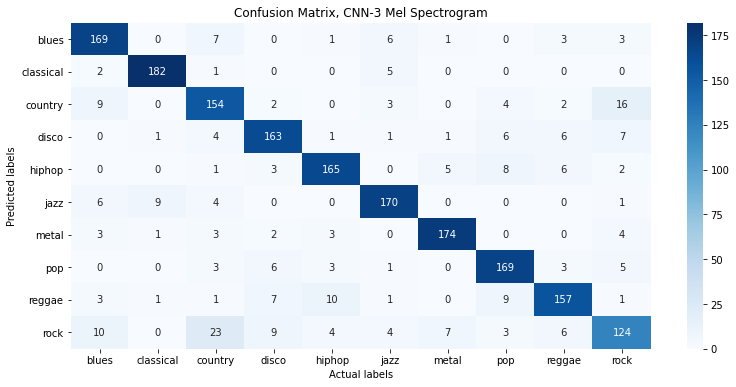

CNN-4
Accuracy: 0.89
Precision macro: 0.8899999999999999
Recall macro: 0.8899728296960168
F1 score macro: 0.8895503555625378
ROC AUC macro: 0.9909473684210525



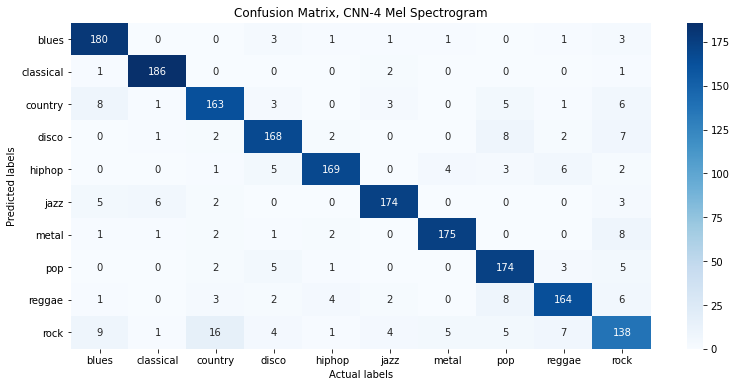

CNN-5
Accuracy: 0.8789473684210526
Precision macro: 0.8789473684210526
Recall macro: 0.8787047941547144
F1 score macro: 0.8781060573843794
ROC AUC macro: 0.9900104647583872



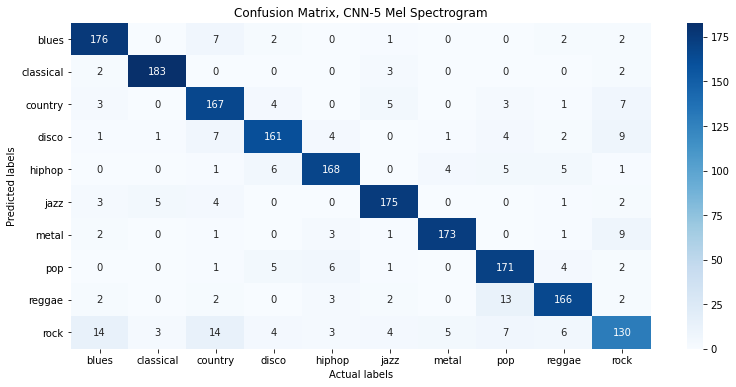

CNN-6
Accuracy: 0.888421052631579
Precision macro: 0.888421052631579
Recall macro: 0.8883473251027943
F1 score macro: 0.887637072212285
ROC AUC macro: 0.9930089258233303



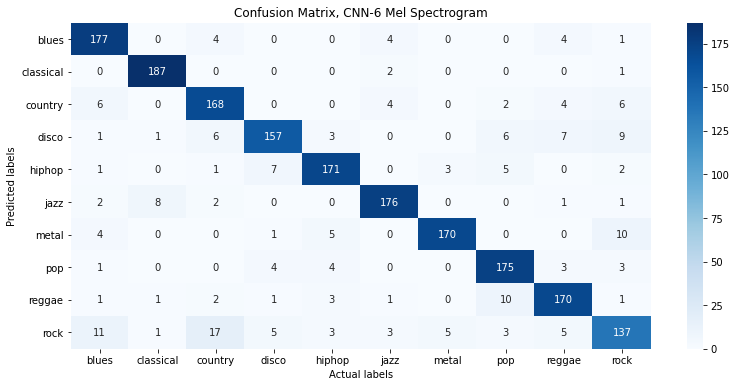

CNN-7
Accuracy: 0.8921052631578947
Precision macro: 0.8921052631578948
Recall macro: 0.8914437842266807
F1 score macro: 0.8914386734339846
ROC AUC macro: 0.9912486919052018



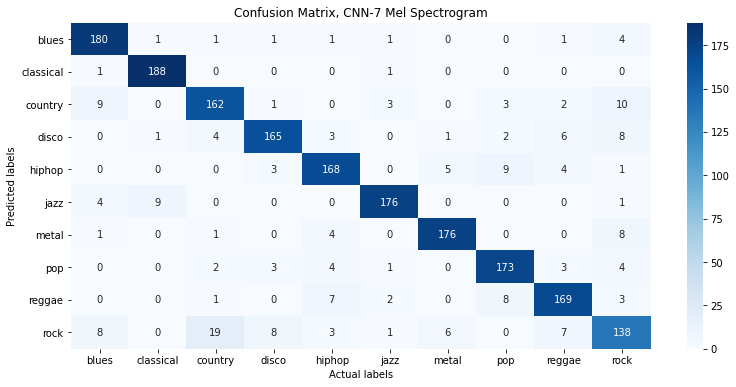

In [ ]:
models = [cnn_3, cnn_4, cnn_5, cnn_6, cnn_7]
predictions_proba = []

for i, model in enumerate(models):
  n_layers = i + 3
  print(f'CNN-{n_layers}')

  # Making predictions on test set
  pred_proba, y_pred = make_predictions(model)
  predictions_proba.append(pred_proba)
  
  # Computing and saving scores
  model_name = f'exp_2_cnn_{n_layers}_mel'
  save_scores(model_name=model_name, pred_proba=pred_proba, y_pred=y_pred)

  # Computing and plotting the confusion matrix
  cm_title = f'Confusion Matrix, CNN-{n_layers} Mel Spectrogram'
  save_path = RESULTS_DIR + f'cm_exp_2_cnn_{n_layers}_mel.png'
  cm = confusion_matrix(y_test, y_pred)
  plot_confusion_matrix(cm, title=cm_title, save_path=save_path)

## 4.2. ROC Comparaison

In [ ]:
plt.style.use('ggplot')

In [ ]:
def compute_roc_curve(y_test, y_score):

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(NUM_CLASSES):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(NUM_CLASSES):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= NUM_CLASSES

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

  return fpr, tpr, roc_auc

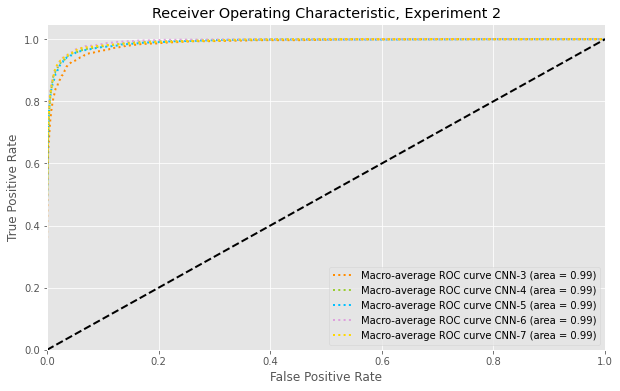

In [ ]:
# Plot linewidth.
lw = 2

# Compute macro-average ROC curve and ROC area
fpr_list, tpr_list, roc_auc_list = [], [], []

for pred_proba in predictions_proba:
  fpr, tpr, roc_auc = compute_roc_curve(one_hot_y_test, pred_proba)
  fpr_list.append(fpr)
  tpr_list.append(tpr)
  roc_auc_list.append(roc_auc)

# Plot all ROC curves
plt.figure(1, figsize=(10,6))
colors = ['darkorange', 'yellowgreen', 'deepskyblue', 'plum', 'gold']

for i in range(5):
  n_layers = i + 3

  plt.plot(fpr_list[i]['macro'], tpr_list[i]['macro'],
          label='Macro-average ROC curve CNN-{0} (area = {1:0.2f})'.format(n_layers, roc_auc_list[i]['macro']),
          color=colors[i], linestyle=':', linewidth=lw)


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, Experiment 2')
plt.legend(loc='lower right')
plt.savefig(RESULTS_DIR + 'exp_2_roc.png')
plt.show()

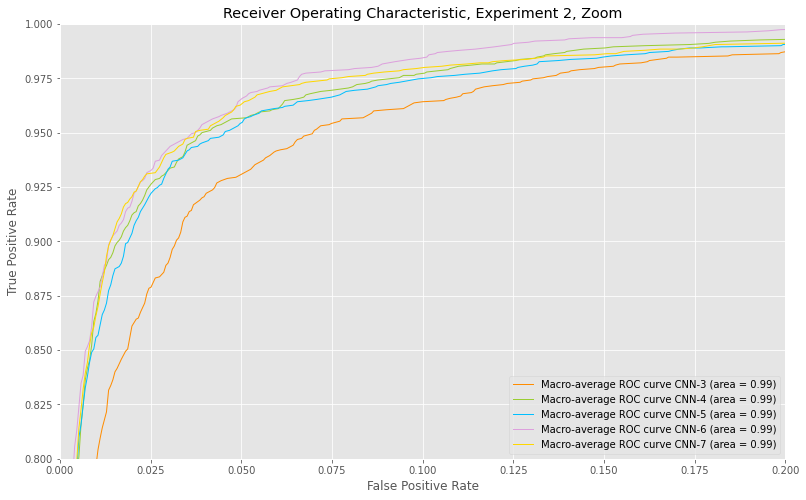

In [ ]:
lw = 1

# Zoom in view of the upper left corner.
plt.figure(2, figsize=(13,8))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
colors = ['darkorange', 'yellowgreen', 'deepskyblue', 'plum', 'gold']

for i in range(5):
  n_layers = i + 3

  plt.plot(fpr_list[i]['macro'], tpr_list[i]['macro'],
          label='Macro-average ROC curve CNN-{0} (area = {1:0.2f})'.format(n_layers, roc_auc_list[i]['macro']),
          color=colors[i], linewidth=lw)


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic, Experiment 2, Zoom')
plt.legend(loc="lower right")
plt.savefig(RESULTS_DIR + 'exp_2_roc_zoom.png')
plt.show()

## 4.3. Per genre
Based on the scores computed above, CNN-7 performs slightly better than the others.

In [ ]:
y_pred_7 = np.argmax(predictions_proba[-1], axis=1)

In [ ]:
fpr_7, tpr_7, roc_auc_7 = fpr_list[-1], tpr_list[-1], roc_auc_list[-1]

__Scores per genre__

In [ ]:
matrix = confusion_matrix(y_test, y_pred_7)
accuracy_per_genre = matrix.diagonal()/matrix.sum(axis=1)
precision_per_genre = precision_score(y_pred_7, y_test, average=None)
recall_per_genre = recall_score(y_pred_7, y_test, average=None, labels=np.unique(y_pred))
f1_score_per_genre = f1_score(y_pred_7, y_test, average=None)

In [ ]:
header = ['genre', 'accuracy', 'precision', 'recall', 'f1_score', 'roc auc']

with open(RESULTS_DIR + 'genre_best_model_scores_per_genre.csv', 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(header)

    for genre in label_map.keys():
      i = label_map[genre]
      scores = [accuracy_per_genre[i], precision_per_genre[i], recall_per_genre[i], f1_score_per_genre[i], roc_auc_7[i]]
      row = [genre]
      row.extend(scores)

      writer.writerow(row)

__ROC Curve__

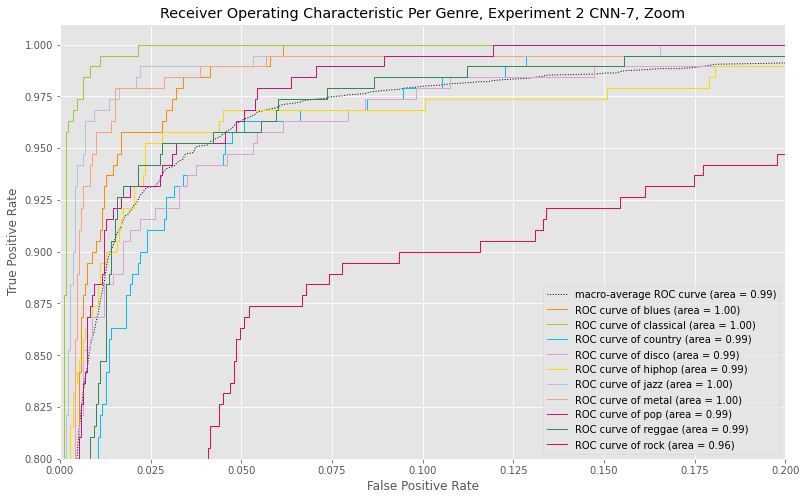

In [ ]:
lw = 1

# Zoom in view of the upper left corner.
plt.figure(3, figsize=(13,8))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1.01)
colors = ['darkorange', 'yellowgreen', 'deepskyblue', 'plum', 
          'gold', 'lightsteelblue', 'lightsalmon', 'mediumvioletred',
          'seagreen', 'crimson']

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='black', linestyle=':', linewidth=lw)


for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_7[i], tpr_7[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(inv_label_map[i], roc_auc_7[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Per Genre, Experiment 2 CNN-7, Zoom')
plt.legend(loc="lower right")
plt.savefig(RESULTS_DIR + 'exp_2_roc_per_genre_zoom.png')
plt.show()

__Reference__

1. <a name='one'> </a> Keunwoo Choi, George Fazekas, and Mark Sandler. [Automatic Tagging Using Deep Convolutional Neural Networks](https://arxiv.org/pdf/1606.00298.pdf), In *17th International Society for Music Information Retrieval Conference, New York, USA*, 2016